GOAL: Using `nn` module to create neural networks easily.

TOC:

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

# Define / Build Neural networks in PyTorch

## Let's design a simple MLP for classifying MNIST images 

<img src="./assets/Part2_figures/example_mlp_arch_mnist.png"></img>

## Load Dataset

In [28]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST(root = '~/.pytorch/MNIST_data/', download=True, train=True, transform=transform) # target_transform
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Let's get a batch of samples:

In [29]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [26]:
print(images.shape)

torch.Size([64, 1, 28, 28])


## 1. Using PyTorch Tensors, the most low-level API, for defining the network

In [38]:
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1) 
print("inputs shape:", inputs.shape)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)
print("w1 shape:", w1.shape)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1) # sigmoid(w*x+b)

out = torch.mm(h, w2) + b2

inputs shape: torch.Size([64, 784])
w1 shape: torch.Size([784, 256])


Similar computations just for one sample:

In [39]:
index = 0
inp = inputs[index,:].unsqueeze(0) # [784] ==> [1, 784]

h = activation(torch.mm(inp, w1) + b1)
out = torch.mm(h, w2) + b2

print(out)

tensor([[-13.7167,  -7.8614,   4.0535,  -2.0203,  16.3859,  -8.9055,   7.5757,
           1.4910, -23.5013,  26.5193]])


sigmoid can bring these values into the range [0,1]:

In [40]:
print(activation(out))

tensor([[1.1038e-06, 3.8518e-04, 9.8294e-01, 1.1709e-01, 1.0000e+00, 1.3562e-04,
         9.9949e-01, 8.1623e-01, 6.2163e-11, 1.0000e+00]])


But, it not a proper probability distribution over the classes.

In [41]:
print(activation(out).sum())

tensor(4.9163)


In the case of multiclass classification, we need to use softmax:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

The probability distribution over the classes tells us the likely class(es) the image belongs to

In [42]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

print(probabilities)
# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

tensor([[3.3549e-18, 1.1712e-15, 1.7507e-10, 4.0309e-13, 3.9730e-05, 4.1227e-16,
         5.9275e-09, 1.3500e-11, 1.8894e-22, 9.9996e-01]])
torch.Size([1, 10])
tensor([1.])


<BarContainer object of 10 artists>

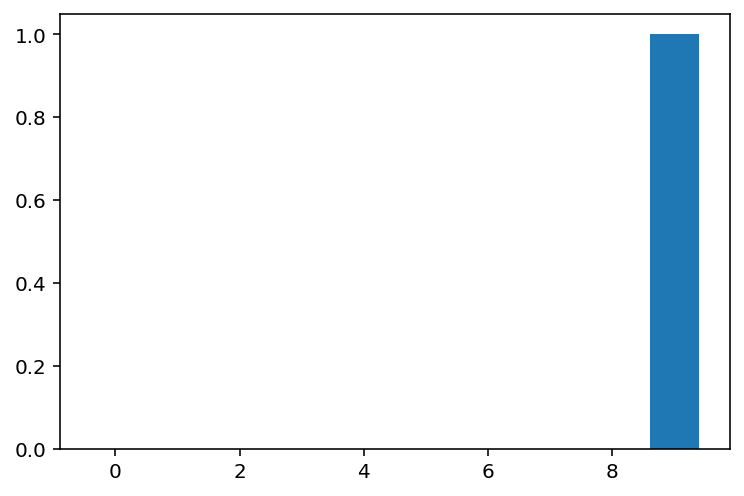

In [43]:
plt.bar(list(range(10)), probabilities.view(-1))

Is that right?

In [44]:
labels[index]

tensor(0)

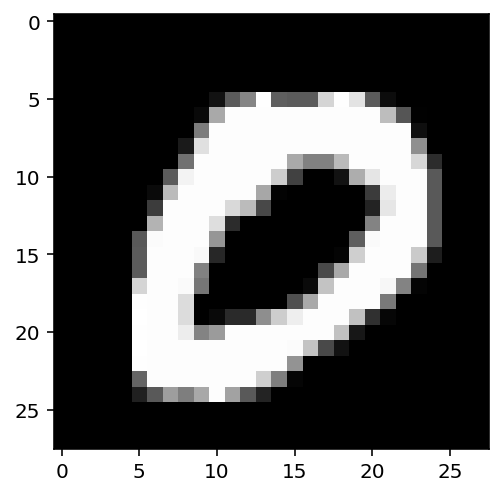

In [45]:
plt.imshow(images[index].numpy().squeeze(), cmap=plt.cm.gray); # images[1,:,:,:]

## 2. Subclassing from ` torch.nn.Module` <a name='subclassing'></a>

PyTorch provides a module `nn` that makes building networks much simpler.

`torch.nn.Module`: This is the PyTorch base class meant to encapsulate behaviors specific to PyTorch Models and their components.

**Note:**

One important behavior of `torch.nn.Module` is registering parameters. If a particular `Module` subclass has learning weights, these weights are expressed as instances of `torch.nn.Parameter`. The `Parameter` class is a subclass of `torch.Tensor`, with the special behavior that when they are assigned as attributes of a `Module`, they are added to the list of that modules parameters. These parameters may be accessed through the `parameters()` method on the `Module` class.

In [1]:
from torch import nn

In [2]:
class Network(nn.Module): # torch.nn.Module
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256) # torch.nn.Linear
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid() # output = nn.Sigmoid()(x)
        self.softmax = nn.Softmax(dim=1) # dim=1: calculates softmax across the columns.
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)     # 784 --> 256
        x = self.sigmoid(x)    # apply sigmoid
        x = self.output(x)     # 256 --> 10
        x = self.softmax(x)    # apply softmax
        
        return x

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. 

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. 

Now we can create a `Network` object.


In [3]:
# Create the network and look at its text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

#### Different ways to access model's paramaters

You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

In [4]:
model.hidden.weight.shape

torch.Size([256, 784])

In [10]:
print('\n\nModel params:')
for param in model.parameters():
    print(param.shape)



Model params:
torch.Size([256, 784])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [11]:
print('\n\nLayer params:')
for param in model.hidden.parameters():
    print(param.shape)



Layer params:
torch.Size([256, 784])
torch.Size([256])


In [14]:
model.hidden.bias.shape

torch.Size([256])

#### Move the model to GPU

In [50]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

model.to(my_device)

Device: cuda


Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

## 3. Using `torch.nn.functional` module <a name='functional'></a>

**Note:**

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

Essentially, `torch.nn.functional` provides building block functions (e.g. layers / activations) in form of **functions**. This means that they can be directly called on the input rather than defining the an object.

When no state or weights are required, `torch.nn.functional` may be used instead of `torch.nn.Module` counterparts. Examples being, resizing (`torch.nn.functional.interpolate`), average pooling (`torch.nn.functional.AvgPool2d`) and activation functions.

In [51]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x)) # output = nn.Sigmoid()(x) versus F.sigmoid(x)
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x


In [53]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

**Note:**

In contrast to `nn.Linear`, to use [`torch.nn.functional.linear()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.linear.html), you need to explicitly feed its weights and biases. This is because of the inherent difference between `torch.nn.functional` and `torch.nn.Module`. E.g., `F.linear(x, param_dict['weight_mean'], param_dict['bias_mean'])`

### Activation functions

So far we've only been looking at the sigmoid and softmax activation functions, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

If no acticvation function is used, we implement only *linear functions;* further, there would be no point to having many layers, as the whole network would reduce could be reduced to a single matrix multiplication. Inserting *non-linear* activation functions between layers is what allows a deep learning model to simulate any function, rather than just linear ones.

`torch.nn.Module` has objects encapsulating all of the major activation functions including ReLU and its many variants, Tanh, Hardtanh, sigmoid, and more. It also includes other functions, such as Softmax, that are most useful at the output stage of a model.

## 4. Using `nn.Sequential` to build a model <a name='seq'></a>

Instead of inheriting directly from `nn.Module`, there is a simpler (but more restrictive) way to build networks.

**Note:**
You cannot build complex models with `nn.Sequential`, i.e., models with:
- shared layers
- multiple input / output / middle branches.
- residual blocks

Some famous models can be built using `nn.Sequential` are LeNet, AlexNet, VGG, etc.
Some famous models cannot be built using `nn.Sequential` are `ResNet`, `Inception`, etc.

In [33]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model) # model(x)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


When you are using `nn.Sequential`, the operations are availble by passing in the appropriate index.

In [35]:
print(model[0]) # model.hidden....
print(model[0].weight.shape)

Linear(in_features=784, out_features=128, bias=True)
torch.Size([128, 784])


You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [18]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now you can access layers either by integer or the name

In [19]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


## Exercise

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use `fc1`, `fc2`, and `fc3` as your layer names.

In [54]:
## Solution
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and biases are automatically initialized for you, but it's possible to customize how they are initialized. 

In [56]:
print(model.fc1.weight.shape)
print(model.fc1.bias.shape)

torch.Size([128, 784])
torch.Size([128])


For custom initialization, we want to modify these tensors in place. These are actually **autograd** *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [57]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0284,  0.0149,  0.0155,  ..., -0.0112, -0.0200,  0.0060],
        [ 0.0025,  0.0011,  0.0055,  ...,  0.0033,  0.0060, -0.0144],
        [ 0.0077, -0.0019, -0.0096,  ...,  0.0030,  0.0093, -0.0265],
        ...,
        [-0.0193,  0.0118,  0.0073,  ...,  0.0073,  0.0005,  0.0032],
        [ 0.0013,  0.0068,  0.0027,  ..., -0.0025,  0.0085,  0.0145],
        [-0.0003,  0.0087,  0.0057,  ..., -0.0079, -0.0064,  0.0025]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

In [59]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [60]:
images.shape

torch.Size([64, 1, 28, 28])

NCHW

NHWC 

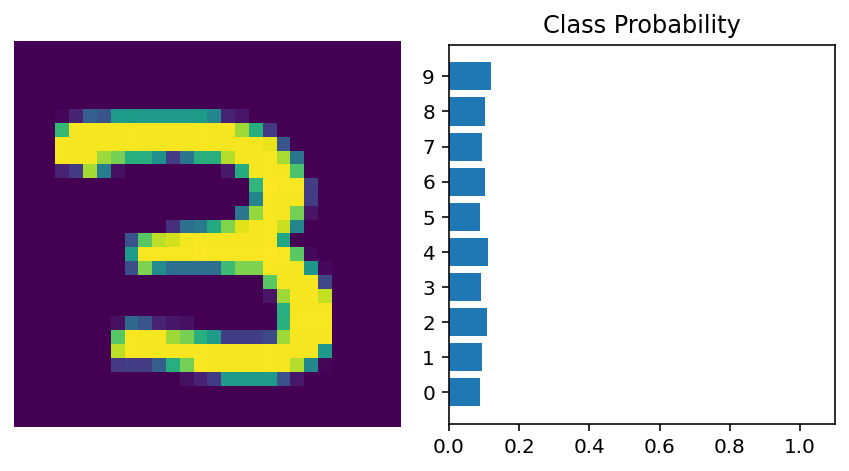

In [61]:
# Resize images into a 1D vector with shape N*C*L
images.resize_(64, 1, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!